# Descripción

Este programa carga 1 archivo, lo limpia, lo segmenta, calcula MFCC + Δ + ΔΔ, grafica y opcionalmente guarda un ```.npy```.

## Celda 1.1 — Imports

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from pathlib import Path

## Celda 1.2 — Ruta

In [2]:
WAV_PATH = Path(r"C:\Users\leona\Documents\Thesis_Project_UACH\Temp\Dataset\BeesAnna\sound_files\2022-06-05--19-39-14_2__segment2.wav")
assert WAV_PATH.exists(), f"No existe el archivo: {WAV_PATH}"
print("OK:", WAV_PATH.name)

OK: 2022-06-05--19-39-14_2__segment2.wav


## Celda 2 — Configuración

In [3]:
SR = 16000
TRIM_DB = 30

SEG_SEC = 2.0
HOP_SEC = 1.0

# MFCC
N_MFCC = 32
N_FFT  = int(0.025 * SR)
HOP_LEN= int(0.010 * SR)
FMIN, FMAX = 20, SR//2

ADD_DELTAS = True


## Celda 3 — Funciones (limpieza, segmentación, MFCC)

In [4]:
def peak_normalize(x, eps=1e-9):
    return x / (np.max(np.abs(x)) + eps)

def segment_signal(x, sr, seg_sec, hop_sec):
    seg_len = int(seg_sec * sr)
    hop_len = int(hop_sec * sr)

    if len(x) < seg_len:
        x = np.pad(x, (0, seg_len - len(x)), mode="reflect")

    segments = []
    for start in range(0, max(1, len(x)-seg_len+1), hop_len):
        seg = x[start:start+seg_len]
        if len(seg) < seg_len:
            seg = np.pad(seg, (0, seg_len - len(seg)), mode="reflect")
        segments.append(seg)
    return segments

def mfcc_features(seg, sr):
    mfcc = librosa.feature.mfcc(
        y=seg, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LEN,
        fmin=FMIN, fmax=FMAX
    )
    if ADD_DELTAS:
        d1 = librosa.feature.delta(mfcc)
        d2 = librosa.feature.delta(mfcc, order=2)
        feat = np.stack([mfcc, d1, d2], axis=0)  # (3, n_mfcc, T)
    else:
        feat = mfcc[np.newaxis, :, :]            # (1, n_mfcc, T)
    return feat.astype(np.float32)



## Celda 4 — Ejecutar pipeline con 1 archivo

In [5]:
# 1) Load + standardize (mono + resample)
x, sr = librosa.load(str(WAV_PATH), sr=SR, mono=True)

dur_before = len(x) / sr

# 2) Trim silence
x_trim, trim_idx = librosa.effects.trim(x, top_db=TRIM_DB)

# 3) Normalize
x_trim = peak_normalize(x_trim)
dur_after = len(x_trim) / sr

# 4) Segment
segments = segment_signal(x_trim, sr, SEG_SEC, HOP_SEC)

# 5) MFCC extraction for all segments
X = np.stack([mfcc_features(seg, sr) for seg in segments], axis=0)  # (N, C, n_mfcc, T)


c:\Users\leona\.conda\envs\envBees\lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


## Celda 5 — Visualizar un segmento

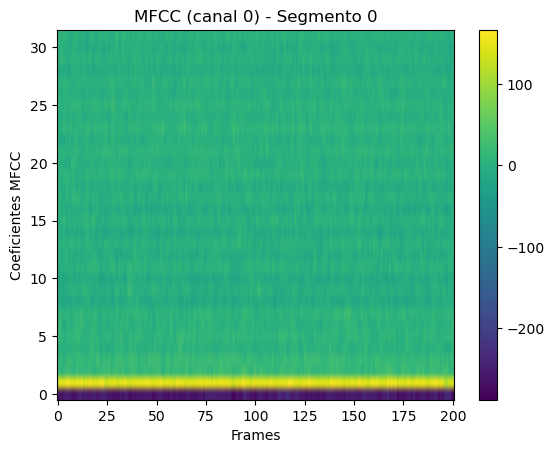

In [6]:
i = 0
plt.figure()
plt.imshow(X[i, 0], aspect="auto", origin="lower")
plt.title(f"MFCC (canal 0) - Segmento {i}")
plt.xlabel("Frames")
plt.ylabel("Coeficientes MFCC")
plt.colorbar()
plt.show()


## Celda 6 — Checklist final (resumen)

In [7]:
def checklist_summary(wav_path, sr, x_raw, x_trim, trim_idx, segments, X):
    checks = {}

    # Audio checks
    checks["file"] = str(wav_path)
    checks["sr"] = sr
    checks["raw_samples"] = int(len(x_raw))
    checks["trim_samples"] = int(len(x_trim))
    checks["duration_raw_s"] = float(len(x_raw)/sr)
    checks["duration_trim_s"] = float(len(x_trim)/sr)
    checks["trim_idx_start_end"] = (int(trim_idx[0]), int(trim_idx[1]))
    checks["raw_min_max"] = (float(np.min(x_raw)), float(np.max(x_raw)))
    checks["trim_min_max"] = (float(np.min(x_trim)), float(np.max(x_trim)))

    checks["raw_has_nan"] = bool(np.isnan(x_raw).any())
    checks["raw_has_inf"] = bool(np.isinf(x_raw).any())
    checks["trim_has_nan"] = bool(np.isnan(x_trim).any())
    checks["trim_has_inf"] = bool(np.isinf(x_trim).any())

    # Segmentation checks
    seg_len = len(segments[0]) if segments else 0
    checks["num_segments"] = int(len(segments))
    checks["segment_samples"] = int(seg_len)
    checks["segment_seconds"] = float(seg_len / sr) if seg_len else 0.0
    checks["all_segments_same_length"] = bool(all(len(s) == seg_len for s in segments)) if segments else False

    # Feature checks
    checks["X_shape"] = tuple(X.shape)  # (N, C, n_mfcc, T)
    checks["X_dtype"] = str(X.dtype)
    checks["X_min_max"] = (float(np.min(X)), float(np.max(X)))
    checks["X_has_nan"] = bool(np.isnan(X).any())
    checks["X_has_inf"] = bool(np.isinf(X).any())

    # Quick “sanity” heuristics
    checks["ok_nonempty"] = (len(x_raw) > 0) and (len(segments) > 0) and (X.size > 0)
    checks["ok_no_nans_infs"] = (not checks["raw_has_nan"]) and (not checks["raw_has_inf"]) and \
                               (not checks["trim_has_nan"]) and (not checks["trim_has_inf"]) and \
                               (not checks["X_has_nan"]) and (not checks["X_has_inf"])
    checks["ok_expected_channels"] = (X.shape[1] == (3 if ADD_DELTAS else 1))
    checks["ok_expected_mfcc"] = (X.shape[2] == N_MFCC)

    return checks

checks = checklist_summary(WAV_PATH, sr, x, x_trim, trim_idx, segments, X)

print("\n========== PIPELINE CHECKLIST ==========")
print(f"Archivo: {checks['file']}")
print(f"SR: {checks['sr']} Hz")
print(f"Duración (raw):  {checks['duration_raw_s']:.2f} s  | muestras: {checks['raw_samples']}")
print(f"Duración (trim): {checks['duration_trim_s']:.2f} s  | muestras: {checks['trim_samples']}")
print(f"Trim idx (start,end): {checks['trim_idx_start_end']}")
print(f"Rango raw (min,max):  {checks['raw_min_max']}")
print(f"Rango trim (min,max): {checks['trim_min_max']}")
print(f"NaN/Inf raw:  {checks['raw_has_nan']}/{checks['raw_has_inf']}")
print(f"NaN/Inf trim: {checks['trim_has_nan']}/{checks['trim_has_inf']}")

print("\n--- Segmentación ---")
print(f"# segmentos: {checks['num_segments']}")
print(f"longitud segmento: {checks['segment_samples']} muestras ({checks['segment_seconds']:.2f} s)")
print(f"todos misma longitud: {checks['all_segments_same_length']}")

print("\n--- Features (MFCC) ---")
print(f"X shape: {checks['X_shape']}  (N, C, n_mfcc, T)")
print(f"X dtype: {checks['X_dtype']}")
print(f"X rango (min,max): {checks['X_min_max']}")
print(f"NaN/Inf X: {checks['X_has_nan']}/{checks['X_has_inf']}")

print("\n--- OK flags ---")
print(f"Non-empty: {checks['ok_nonempty']}")
print(f"No NaN/Inf: {checks['ok_no_nans_infs']}")
print(f"Channels OK: {checks['ok_expected_channels']} (esperado: {3 if ADD_DELTAS else 1})")
print(f"n_mfcc OK: {checks['ok_expected_mfcc']} (esperado: {N_MFCC})")
print("========================================\n")



========== PIPELINE CHECKLIST ==========
Archivo: C:\Users\leona\Documents\Thesis_Project_UACH\Temp\Dataset\BeesAnna\sound_files\2022-06-05--19-39-14_2__segment2.wav
SR: 16000 Hz
Duración (raw):  60.00 s  | muestras: 960000
Duración (trim): 60.00 s  | muestras: 960000
Trim idx (start,end): (0, 960000)
Rango raw (min,max):  (-0.27253592014312744, 0.2996368408203125)
Rango trim (min,max): (-0.909554123878479, 1.0)
NaN/Inf raw:  False/False
NaN/Inf trim: False/False

--- Segmentación ---
# segmentos: 59
longitud segmento: 32000 muestras (2.00 s)
todos misma longitud: True

--- Features (MFCC) ---
X shape: (59, 3, 32, 201)  (N, C, n_mfcc, T)
X dtype: float32
X rango (min,max): (-315.1804504394531, 173.0443878173828)
NaN/Inf X: False/False

--- OK flags ---
Non-empty: True
No NaN/Inf: True
Channels OK: True (esperado: 3)
n_mfcc OK: True (esperado: 32)



# RELACIÓN CON EL *.CSV

A continuación se lee el CSV, buscando coincidencias, y se obtiene PASS/FAIL + algunos contadores para saber qué tan mal/bien está la relación entre los archivos de audio y las etiquetas.

> En las siguientes celdas se asume que el CSV tiene una columna con el nombre del archivo (por ejemplo ```filename```) y una columna de etiqueta (por ejemplo ```queen_present```). Si los nombres son distintos, solo se cambia ```ID_COL``` y ```TARGET_COL```.

## Celda 1 — Configura rutas y columnas

In [ ]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path(r"C:\Users\leona\Documents\Thesis_Project_UACH\Temp\Dataset\BeesAnna\sound_files")
CSV_PATH = Path(r"C:\Users\leona\Documents\Thesis_Project_UACH\Development(Code)\Datasets\BeeHive_audio_updated.csv")

ID_COL = "file name"            # <-- cambia si se llama distinto
TARGET_COL = "queen status"    # <-- cambia si se llama distinto

assert DATA_DIR.exists(), f"No existe DATA_DIR: {DATA_DIR}"
assert CSV_PATH.exists(), f"No existe CSV_PATH: {CSV_PATH}"
print("OK rutas")

OK rutas


In [ ]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path(r"C:\Users\leona\Documents\Thesis_Project_UACH\Temp\Dataset\BeesAnna\sound_files")
CSV_PATH = Path(r"C:\RUTA\A\TU_ARCHIVO.csv")  # <-- cambia esto

ID_COL = "filename"          # <-- ajusta al nombre real
TARGET_COL = "queen_present" # <-- ajusta al nombre real

# WAVs en carpeta
wav_paths = sorted(list(DATA_DIR.rglob("*.wav"))) + sorted(list(DATA_DIR.rglob("*.WAV")))
wav_names = set(p.name for p in wav_paths)

# CSV
df = pd.read_csv(CSV_PATH)

if ID_COL not in df.columns:
    print("FAIL: falta ID_COL =", ID_COL)
elif TARGET_COL not in df.columns:
    print("FAIL: falta TARGET_COL =", TARGET_COL)
else:
    # Normaliza nombres (solo basename)
    df["_basename"] = df[ID_COL].astype(str).map(lambda s: Path(s).name)

    # Filtra filas con etiqueta válida (no vacía)
    y = df[TARGET_COL]
    labeled = df.loc[y.notna() & (y.astype(str).str.strip() != ""), ["_basename", TARGET_COL]].copy()

    labeled_names = set(labeled["_basename"])
    matched_labeled = labeled_names.intersection(wav_names)
    missing_labeled_in_folder = labeled_names - wav_names

    labeled_coverage = (len(matched_labeled) / max(1, len(labeled_names))) * 100.0
    unlabeled_wavs_in_folder = wav_names - labeled_names  # WAVs que no aparecen como etiquetados

    print("----- Resumen (enfocado a etiquetados) -----")
    print("WAVs totales en carpeta:", len(wav_names))
    print("Filas etiquetadas en CSV:", len(labeled_names))
    print("Etiquetados encontrados en carpeta:", len(matched_labeled))
    print("Cobertura de etiquetados (found/labeled): {:.2f}%".format(labeled_coverage))
    print("Etiquetados en CSV pero NO en carpeta:", len(missing_labeled_in_folder))
    print("WAVs no etiquetados (en carpeta):", len(unlabeled_wavs_in_folder))

    if labeled_coverage >= 98:
        print("\nPASS: el enlace CSV↔WAV para los etiquetados es correcto.")
    else:
        print("\nFAIL: faltan muchos etiquetados; hay problema de nombres/rutas.")
        print("Ejemplos faltantes (hasta 10):", list(missing_labeled_in_folder)[:10])

## Celda 2 — Prueba de enlace CSV ↔ WAV (PASS/FAIL)

In [10]:
# 1) listar WAVs
wav_paths = sorted(list(DATA_DIR.rglob("*.wav"))) + sorted(list(DATA_DIR.rglob("*.WAV")))
wav_names = set(p.name for p in wav_paths)

# 2) leer CSV
df = pd.read_csv(CSV_PATH)

# validar columnas
if ID_COL not in df.columns:
    print("FAIL: el CSV no tiene la columna ID_COL =", ID_COL)
elif TARGET_COL not in df.columns:
    print("FAIL: el CSV no tiene la columna TARGET_COL =", TARGET_COL)
else:
    # 3) normalizar nombres: usar solo basename para que no importen rutas
    csv_names = df[ID_COL].astype(str).map(lambda s: Path(s).name)
    csv_names_set = set(csv_names)

    # 4) matches
    matched = csv_names_set.intersection(wav_names)
    missing_in_folder = csv_names_set - wav_names    # están en CSV pero no en carpeta
    missing_in_csv = wav_names - csv_names_set       # están en carpeta pero no en CSV

    # 5) etiquetas "válidas" (no vacías)
    y = df[TARGET_COL]
    labeled_rows = df.loc[y.notna() & (y.astype(str).str.strip() != "")].copy()

    # 6) Resultado binario: PASS si hay matches y la mayoría está cubierta
    coverage = (len(matched) / max(1, len(wav_names))) * 100.0

    print("----- Resumen -----")
    print("WAVs encontrados:", len(wav_names))
    print("Filas CSV:", len(df))
    print("WAVs con match (por nombre):", len(matched))
    print("Cobertura aproximada (match/WAVs): {:.2f}%".format(coverage))
    print("En CSV pero NO en carpeta:", len(missing_in_folder))
    print("En carpeta pero NO en CSV:", len(missing_in_csv))
    print("Filas con etiqueta no vacía en TARGET_COL:", len(labeled_rows))

    # criterio simple PASS/FAIL
    # (ajusta si quieres más estricto)
    if len(matched) > 0 and coverage >= 80:
        print("\nPASS: el CSV enlaza con los WAVs (suficiente cobertura).")
    else:
        print("\nFAIL: el enlace CSV↔WAV no es confiable (poca cobertura o cero matches).")

----- Resumen -----
WAVs encontrados: 7100
Filas CSV: 1275
WAVs con match (por nombre): 0
Cobertura aproximada (match/WAVs): 0.00%
En CSV pero NO en carpeta: 1275
En carpeta pero NO en CSV: 7100
Filas con etiqueta no vacía en TARGET_COL: 1275

FAIL: el enlace CSV↔WAV no es confiable (poca cobertura o cero matches).


## Celda 3 — (Opcional) Mostrar ejemplos si falla (sin guardar)

In [ ]:
# Solo para inspección rápida si algo salió mal
# Muestra 5 nombres de cada lado para ver el formato

print("\nEjemplos WAV en carpeta:")
for p in list(wav_paths)[:5]:
    print(" -", p.name)

df = pd.read_csv(CSV_PATH)
print("\nEjemplos ID en CSV:")
for s in df[ID_COL].astype(str).head(5):
    print(" -", s)